<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/PetBreeder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">PetBreeder v.1.1</font></b>

![visitors](https://visitor-badge.glitch.me/badge?page_id=mlart.PetBreeder&left_color=black&right_color=orange)

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [StyleAlign](https://github.com/betterze/StyleAlign), [encoder4editing](https://github.com/omertov/encoder4editing)

Creators: **[Zongze Wu](https://github.com/betterze), [omertov](https://github.com/omertov)**

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@MLArt](https://t.me/MLArt),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---

- **upd 1.1** - Added cat face generation model.
- **1.0** - Created a Colab that generates a dog's face from a human's face.

---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, поочередно нажимайте на кнопки (куда указывают красные стрелки), дожидаясь завершения выполнения каждого блока.
```


In [1]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые библиотеки</font></b>

#@markdown **First of all follow this link (прежде всего перейдите по ссылке):**

#@markdown **https://drive.google.com/drive/folders/1Urn2xrI1sjQWkmdSJmaPIPjK6KhAinvv**

#@markdown **if link doesn't work please refer to [@bomze](https://t.me/bomze) (если ссылка не работает, обратитесь к [@bomze](https://t.me/bomze).)**

#@markdown **1) right click on 'checkpoints_PetBreeder' (правой кнопкой по checkpoints_PetBreeder)**

#@markdown **2) select 'Add shortcut to Drive (выберите Сохранить ярлык на Диск)**

#@markdown ![](https://github.com/tg-bomze/collection-of-notebooks/raw/master/dfs.png)

#@markdown **3) run this block and follow the further instructions (после этого запустите блок и следуйте инструкции)**

#@markdown *Attention! If the weights have already been saved, then run this block and just mount Google Drive.*

#@markdown *Внимание! Если веса уже сохранены, то можете сразу запустить блок и смонтировать Google Drive.*

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

!mkdir /content/frames
!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
from google.colab import files
from IPython.display import clear_output
from IPython.display import HTML
from base64 import b64encode
import time
import os
import os.path
import sys
import numpy as np
from PIL import Image
import glob
from tqdm import tqdm
import torch
from torch import nn
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
#from models.psp import pSp 
from models.encoders import psp_encoders
from models.stylegan2.model import Generator

transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

if 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image

def gen_im(model_type='ffhq'):
  if model_type=='ffhq':
    imgs, _ = ffhq_decoder([ffhq_codes], input_is_latent=True, randomize_noise=False, return_latents=True)
  elif model_type=='dog':
    imgs, _ = dog_decoder([dog_codes], input_is_latent=True, randomize_noise=False, return_latents=True)
  elif model_type=='cat':
    imgs, _ = cat_decoder([cat_codes], input_is_latent=True, randomize_noise=False, return_latents=True)
  else:
    imgs, _ = custom_decoder([custom_codes], input_is_latent=True, randomize_noise=False, return_latents=True)
  return tensor2im(imgs[0])

ratio_list = [round(i/100, 2) for i in list(range(101))]
!pip install -U gdown
!set -exo
if os.path.isfile('shape_predictor_68_face_landmarks.dat'):
  clear_output()
  print('Done!')
else:
  print('Something wrong')
%load_ext autoreload
%autoreload 2

In [3]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Models uploading</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузка моделей</font></b>
%cd /content/encoder4editing
ffhq_model_path = '/content/drive/MyDrive/checkpoints_DogBreeder/e4e_ffhq512.pt'
print('[1/3] Uploading human face model...')
if not os.path.isfile(ffhq_model_path):
  !gdown --id 1Asq4ngrjEJrFwO4CA8woZr2Rx1hsH8i9
  ffhq_model_path = '/content/encoder4editing/e4e_ffhq512.pt'

ffhq_ckpt = torch.load(ffhq_model_path, map_location='cpu')
ffhq_latent_avg = ffhq_ckpt['latent_avg'].to('cuda:0')
ffhq_opts = ffhq_ckpt['opts']
ffhq_opts['checkpoint_path'] = ffhq_model_path
ffhq_opts= Namespace(**ffhq_opts)

ffhq_encoder = psp_encoders.Encoder4Editing(50, 'ir_se', ffhq_opts)
ffhq_e_filt = {k[len('encoder') + 1:]: v for k, v in ffhq_ckpt['state_dict'].items() if k[:len('encoder')] == 'encoder'}
ffhq_encoder.load_state_dict(ffhq_e_filt, strict=True)
ffhq_encoder.eval()
ffhq_encoder.cuda()

ffhq_decoder = Generator(512, 512, 8, channel_multiplier=2)
ffhq_d_filt = {k[len('decoder') + 1:]: v for k, v in ffhq_ckpt['state_dict'].items() if k[:len('decoder')] == 'decoder'}
ffhq_decoder.load_state_dict(ffhq_d_filt, strict=True)
ffhq_decoder.eval()
ffhq_decoder.cuda()
clear_output()

dog_model_path = '/content/drive/MyDrive/checkpoints_DogBreeder/e4e_ffhq512_dog.pt'
print('[2/3] Uploading dog face model...')
if not os.path.isfile(ffhq_model_path):
  !gdown --id 1pFaKmeQRdq8svTG3wIANkvufjgf0RekC
  dog_model_path = '/content/encoder4editing/e4e_ffhq512_dog.pt'

dog_ckpt = torch.load(dog_model_path, map_location='cpu')
dog_latent_avg = dog_ckpt['latent_avg'].to('cuda:0')
dog_opts = dog_ckpt['opts']
dog_opts['checkpoint_path'] = dog_model_path
dog_opts= Namespace(**dog_opts)

dog_encoder = psp_encoders.Encoder4Editing(50, 'ir_se', dog_opts)
dog_e_filt = {k[len('encoder') + 1:]: v for k, v in dog_ckpt['state_dict'].items() if k[:len('encoder')] == 'encoder'}
dog_encoder.load_state_dict(dog_e_filt, strict=True)
dog_encoder.eval()
dog_encoder.cuda()

dog_decoder = Generator(512, 512, 8, channel_multiplier=2)
dog_d_filt = {k[len('decoder') + 1:]: v for k, v in dog_ckpt['state_dict'].items() if k[:len('decoder')] == 'decoder'}
dog_decoder.load_state_dict(dog_d_filt, strict=True)
dog_decoder.eval()
dog_decoder.cuda()
clear_output()

cat_model_path = '/content/drive/MyDrive/checkpoints_DogBreeder/e4e_ffhq512_cat.pt'
print('[3/3] Uploading cat face model...')
if not os.path.isfile(ffhq_model_path):
  !gdown --id 19kAog3hx8vE45DxMuJCR4fXboD-kPIv0
  cat_model_path = '/content/encoder4editing/e4e_ffhq512_cat.pt'

cat_ckpt = torch.load(cat_model_path, map_location='cpu')
cat_latent_avg = cat_ckpt['latent_avg'].to('cuda:0')
cat_opts = cat_ckpt['opts']
cat_opts['checkpoint_path'] = cat_model_path
cat_opts= Namespace(**cat_opts)

cat_encoder = psp_encoders.Encoder4Editing(50, 'ir_se', cat_opts)
cat_e_filt = {k[len('encoder') + 1:]: v for k, v in cat_ckpt['state_dict'].items() if k[:len('encoder')] == 'encoder'}
cat_encoder.load_state_dict(cat_e_filt, strict=True)
cat_encoder.eval()
cat_encoder.cuda()

cat_decoder = Generator(512, 512, 8, channel_multiplier=2)
cat_d_filt = {k[len('decoder') + 1:]: v for k, v in cat_ckpt['state_dict'].items() if k[:len('decoder')] == 'decoder'}
cat_decoder.load_state_dict(cat_d_filt, strict=True)
cat_decoder.eval()
cat_decoder.cuda()
clear_output()

print('Done!')

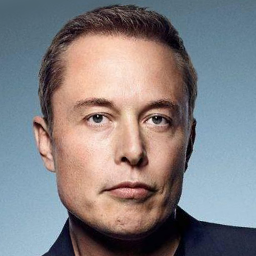

In [4]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload photo</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить фото</font></b>

uploaded = files.upload()
for image_path in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=image_path, length=len(uploaded[image_path])))

input_image = run_alignment(image_path)
transformed_image = transform(input_image)

ffhq_codes = ffhq_encoder(transformed_image.unsqueeze(0).to("cuda").float())
ffhq_codes = ffhq_codes + ffhq_latent_avg.repeat(ffhq_codes.shape[0], 1, 1)

cat_codes = cat_encoder(transformed_image.unsqueeze(0).to("cuda").float())
#cat_codes = cat_codes + cat_latent_avg.repeat(cat_codes.shape[0], 1, 1)
cat_codes = cat_codes + ffhq_latent_avg.repeat(cat_codes.shape[0], 1, 1)

dog_codes = dog_encoder(transformed_image.unsqueeze(0).to("cuda").float())
#dog_codes = dog_codes + dog_latent_avg.repeat(dog_codes.shape[0], 1, 1)
dog_codes = dog_codes + ffhq_latent_avg.repeat(dog_codes.shape[0], 1, 1)

clear_output()
input_image.resize(resize_dims)

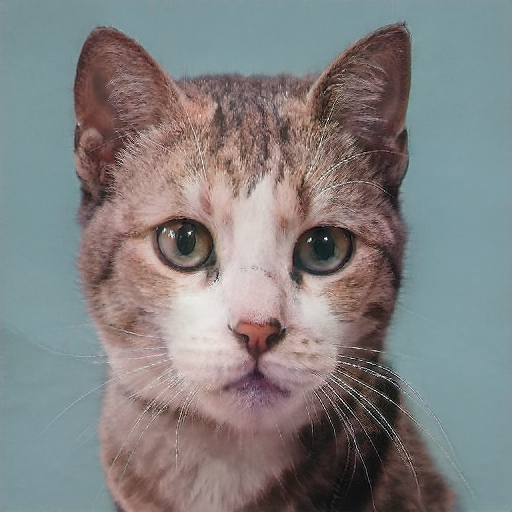

In [5]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generate animal</font></b> {run: "auto"}
#@markdown <b><font color="black" size="+1"> (RUS) Сгенерировать животное</font></b>
animal = "cat" #@param ["dog", "cat"]
gen_im(animal)

In [6]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Create animation</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Создать анимацию</font></b>
animal = "dog" #@param ["dog", "cat"]
!rm -rf /content/frames/*
for ratio in tqdm(ratio_list):
  custom_decoder = Generator(512, 512, 8, channel_multiplier=2)
  custom_d_filt = {k[len('decoder') + 1:]: v for k, v in ffhq_ckpt['state_dict'].items() if k[:len('decoder')] == 'decoder'}
  for i in ffhq_d_filt:
    if animal == 'dog':
      custom_d_filt[i] = (ffhq_d_filt[i]*(1-ratio)) + (dog_d_filt[i]*ratio)
    else:
      custom_d_filt[i] = (ffhq_d_filt[i]*(1-ratio)) + (cat_d_filt[i]*ratio)
  custom_decoder.load_state_dict(custom_d_filt, strict=True)
  custom_decoder.eval()
  custom_decoder.cuda()

  if animal == 'dog':
    custom_codes = (ffhq_codes*(1-ratio)) + (dog_codes*ratio)
  else: custom_codes = (ffhq_codes*(1-ratio)) + (cat_codes*ratio)

  name = str(len(glob.glob('/content/frames/*.*g'))).zfill(7)
  gen_im('custom').save(f'/content/frames/{name}.png')

!ffmpeg -y -r 25 -i /content/frames/%07d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p /content/result.mp4 -hide_banner -loglevel error

clear_output()
input_clip = open('/content/result.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(input_clip).decode()
HTML("""<video width=512 controls><source src="%s" type="video/mp4"></video>""" % data_url)